<a href="https://colab.research.google.com/github/AsutoshDalei/Deep-Neural-Networks/blob/master/GenerateSketches.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generate Sketches

Humans have used sketching to depict our visual world since prehistoric times. Even today, sketching is possibly the only rendering technique readily available to all humans. This paper is the first large scale exploration of human sketches. We analyze the distribution of non-expert sketches of everyday objects such as 'teapot' or 'car'. We ask humans to sketch objects of a given category and gather 20,000 unique sketches evenly distributed over 250 object categories.

https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/

In [29]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
import matplotlib.image as mpimg


## Data Collection
Fetcing and unzipping

In [8]:
# !wget https://cybertron.cg.tu-berlin.de/eitz/projects/classifysketch/sketches_png.zip

# !unzip /content/sketches_png.zip

In [12]:
numImgs,sktName = [],[]

hmap = {"fileName":[],'object':[],'path':[]}
hmap = {"fileName":[],'object':[]}

dataPath = "/content/png"

for ele in os.listdir(dataPath):
  if os.path.isdir(f"{dataPath}/{ele}"):
    # print(f"{ele} is a dir")
    numClassImg = len(os.listdir(f"{dataPath}/{ele}"))
    numImgs.append(numClassImg)
    sktName.append(ele)

    hmap['fileName'].extend(os.listdir(f"{dataPath}/{ele}"))
    hmap['object'].extend([ele]*len(os.listdir(f"{dataPath}/{ele}")))
    # hmap['path'].extend()

  else:
    print(f"{ele} is a file")

print(f"Number of objects sketched: {len(numImgs)}")

print(f"Average number of images per object: {sum(numImgs)/len(numImgs)}")

filelist.txt is a file
Number of objects sketched: 250
Average number of images per object: 80.0


In [26]:
%%time
data = pd.DataFrame(hmap)
data = data.assign(path = data.apply(lambda row: f"{dataPath}/{row['object']}/{row['fileName']}",axis=1))
data.head()

CPU times: user 135 ms, sys: 2.92 ms, total: 138 ms
Wall time: 138 ms


,fileName,object,path
0,10747.png,motorbike,/content/png/motorbike/10747.png
1,10790.png,motorbike,/content/png/motorbike/10790.png
2,10788.png,motorbike,/content/png/motorbike/10788.png
3,10795.png,motorbike,/content/png/motorbike/10795.png
4,10793.png,motorbike,/content/png/motorbike/10793.png


---
### Viewing Sketches

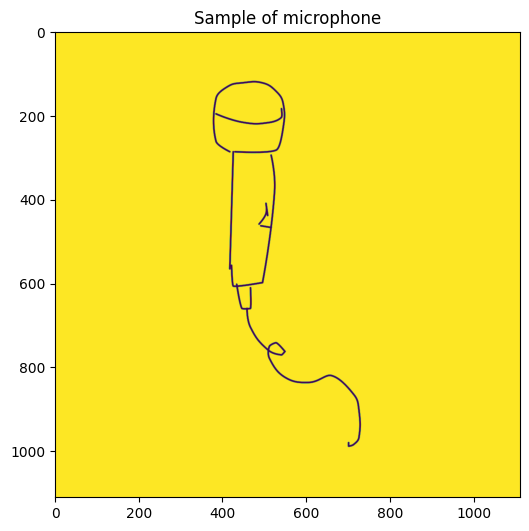

In [49]:
sample = data.sample(1)

def showSketch_init(sample):
  plt.figure(figsize=(6,7),dpi=100)
  img = plt.imread(sample['path'].item())
  imgplot = plt.imshow(img)
  plt.title(f"Sample of {sample['object'].item()}")
  plt.show()

showSketch_init(sample)

In [60]:
img = plt.imread(sample['path'].item())
img

array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]], dtype=float32)